In [4]:
import os
import pywt
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签SimHei
plt.rcParams['axes.unicode_minus'] = False # 用来正常显示负号
from pandas import DataFrame
from pandas import concat#相空间重构用到的包
import seaborn as sns
from scipy.stats import pearsonr
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [5]:
#导入csv文件
df=pd.read_csv(r'D:\article\2023年2月-2024年1月海南数据.csv',encoding="ANSI")
names=df.columns#查看列名
df

date_time     power  windspeed        tem        hum     pressure  \
0       2/1 0h  0.105113   4.725235  18.655389  92.949128  1010.694063   
1       2/1 1h  0.081281   4.367065  18.587457  93.587855  1010.506875   
2       2/1 2h  0.063762   4.103956  18.515161  94.263234  1010.098750   
3       2/1 3h  0.044355   3.728412  18.144342  95.350790  1009.648750   
4       2/1 4h  0.022835   3.261689  17.879816  96.169491  1009.809844   
...        ...       ...        ...        ...        ...          ...   
8755  1/31 19h  0.502221   7.868399  21.896021  86.729371  1013.471797   
8756  1/31 20h  0.454104   7.592676  21.634698  88.164145  1014.018750   
8757  1/31 21h  0.368684   7.106822  21.238000  90.249705  1014.392031   
8758  1/31 22h  0.277844   6.454990  20.962213  91.737839  1014.452969   
8759  1/31 23h  0.211935   5.939397  20.809259  92.732038  1014.556641   

      precipitation    wind_dir  
0          0.000847  129.363464  
1          0.000847  134.816971  
2          0.001552  137.654510  
3          0.003809  135.064087  
4          0.009029  128.642273  
...             ...         ...  
8755       0.000000  110.521469  
8756       0.000000  119.941391  
8757       0.000000  128.919601  
8758       0.000000  133.907013  
8759       0.000000  133.937012  

[8760 rows x 8 columns]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


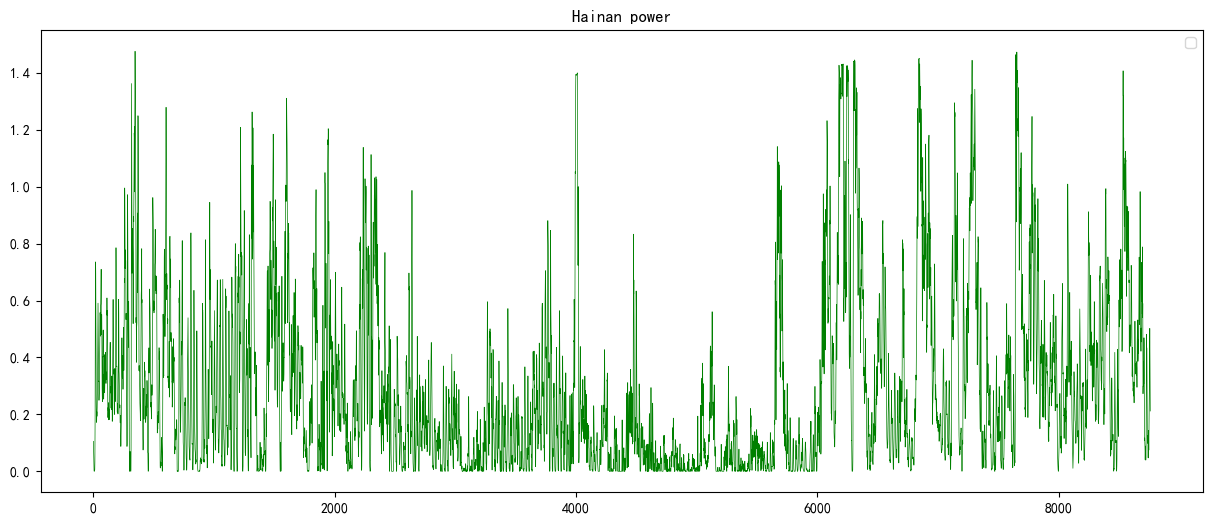

In [6]:
#对海南风功率原始进行可视化
plt.figure(figsize=(15,6))
plt.plot(df["power"],color='green', linewidth=0.5)
plt.title("Hainan power")
plt.legend()
plt.show()

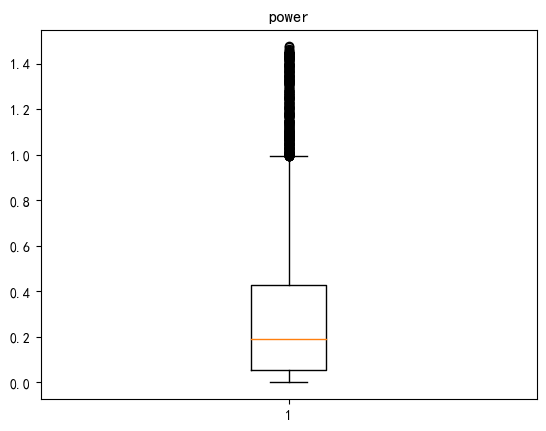

In [7]:
import matplotlib.pyplot as plt
# 显示图表
plt.subplot(1,1,1)
plt.boxplot(df["power"])
plt.title("power")
plt.show()

In [8]:
# 计算四分位数
Q1 = df["power"].quantile(0.25)
Q2 = df["power"].quantile(0.5)
Q3 = df["power"].quantile(0.75)

# 打印四分位数
print("第一四分位数 (Q1):", Q1)
print("中位数 (Q2, 即第二四分位数):", Q2)
print("第三四分位数 (Q3):", Q3)

第一四分位数 (Q1): 0.0529387035
中位数 (Q2, 即第二四分位数): 0.1899624805
第三四分位数 (Q3): 0.4293890595


In [9]:
# 获取最大值
max_power = df["power"].max()

# 打印最大值
print("最大值:", max_power)

最大值: 1.47614515


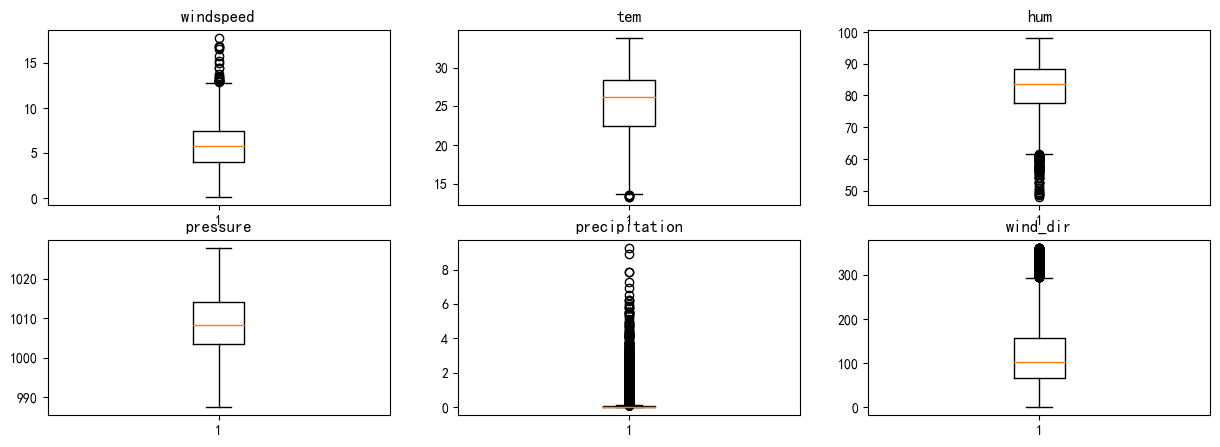

In [10]:
#异常值检测
fig,axs=plt.subplots(2,3,figsize=(15,5))
axs[0,0].boxplot(df["windspeed"])
axs[0,0].set_title('windspeed')
axs[0,1].boxplot(df["tem"])
axs[0,1].set_title('tem')
axs[0,2].boxplot(df["hum"])
axs[0,2].set_title('hum')
axs[1,0].boxplot(df["pressure"])
axs[1,0].set_title('pressure')
axs[1,1].boxplot(df["precipitation"])
axs[1,1].set_title('precipitation')
axs[1,2].boxplot(df["wind_dir"])
axs[1,2].set_title('wind_dir')
plt.show()

Text(0.5, 1.0, 'power')

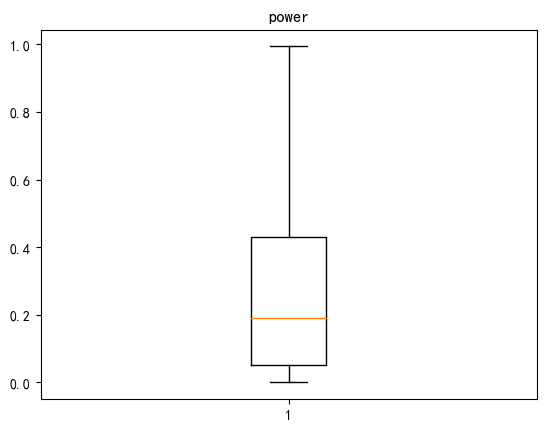

In [11]:
#处理异常值(box-plot-四分数法)
Q=df['power'].quantile([0.25,0.5,0.75])
Q1=df['power'].quantile(0.25)
Q2=df['power'].quantile(0.5)
Q3=df['power'].quantile(0.75)
IQR=Q3-Q1
#计算上下限
up=Q3+1.5*IQR
lw= Q1-1.5*IQR
newdata=[lw if x< lw else x for x in df['power']]
new_power=[up if x> up else x for x in newdata]#将数据集中在上下界，用lw替换下界，用up替换上界
#处理异常值之后的风速数据
plt.subplot(1,1,1)
plt.boxplot(new_power)
plt.title("power")

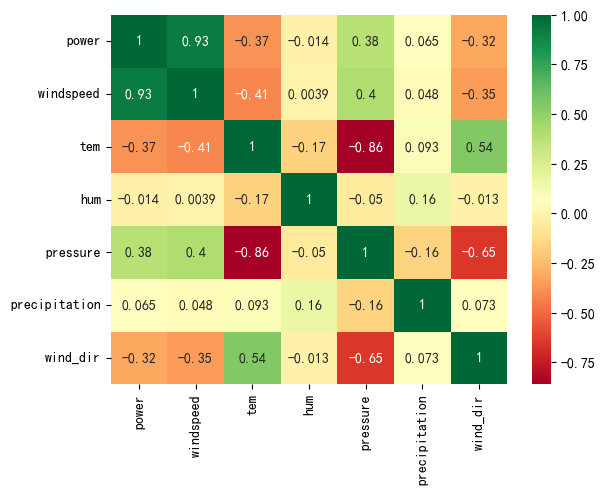

In [12]:
##对影响因素进行分析
#绘制热力图表明各变量之间的相关性
person=df[['power','windspeed','tem','hum','pressure','precipitation','wind_dir']]
#使用numpy来求皮尔森相关系数
cor_1=np.corrcoef(person,rowvar=False)#rowvar=False时计算的是列与列之间(即随机变量)的相关性
X1=pd.DataFrame(df,names)
x_ticks = ['power','windspeed','tem','hum','pressure','precipitation','wind_dir']
y_ticks = ['power','windspeed','tem','hum','pressure','precipitation','wind_dir']
ax=sns.heatmap(cor_1,xticklabels=x_ticks, yticklabels=y_ticks,vmax=1,cmap='RdYlGn',annot=True)
plt.show()
#结果表明，风功率与风速、温度、压强、风向关系较为密切

In [13]:
#为了方便处理，将数据框第一列删除
# 假设df是已经存在的DataFrame
df = df.drop(['date_time','hum','precipitation'], axis=1)
df

power  windspeed        tem     pressure    wind_dir
0     0.105113   4.725235  18.655389  1010.694063  129.363464
1     0.081281   4.367065  18.587457  1010.506875  134.816971
2     0.063762   4.103956  18.515161  1010.098750  137.654510
3     0.044355   3.728412  18.144342  1009.648750  135.064087
4     0.022835   3.261689  17.879816  1009.809844  128.642273
...        ...        ...        ...          ...         ...
8755  0.502221   7.868399  21.896021  1013.471797  110.521469
8756  0.454104   7.592676  21.634698  1014.018750  119.941391
8757  0.368684   7.106822  21.238000  1014.392031  128.919601
8758  0.277844   6.454990  20.962213  1014.452969  133.907013
8759  0.211935   5.939397  20.809259  1014.556641  133.937012

[8760 rows x 5 columns]

In [14]:
#将数据划分为四季（按实际意义划分）
import pandas as pd
spring= df.iloc[744:2880]  # 注意索引是从0开始的，所以234行实际上是索引233
summer=df.iloc[2880:5088]
autumn=df.iloc[5088:7296]
winter_1=df.iloc[7296:8760]
winter_2=df.iloc[1:744]
# 合并两个选取的行到一个新的数据框
winter = pd.concat([winter_1, winter_2], ignore_index=True)

In [15]:
#将数据框分为训练集和测试集
from sklearn.model_selection import train_test_split
train_spring, test_spring = train_test_split(spring, test_size=0.2, random_state=42,shuffle=False)
train_summer, test_summer = train_test_split(summer, test_size=0.2, random_state=42,shuffle=False)
train_autumn, test_autumn = train_test_split(autumn, test_size=0.2, random_state=42,shuffle=False)
train_winter, test_winter = train_test_split(winter, test_size=0.2, random_state=42,shuffle=False)

In [16]:
#对春天的训练集和测试集进行可视化
t1_1=range(1,len(train_spring)+1)
t1_2=range(len(train_spring),len(spring))
plt.figure(figsize=(15,6))
plt.plot(t1_1,train_spring["power"],color='blue', linewidth=0.8,label='train')
plt.plot(t1_2,test_spring["power"],color='green', linewidth=0.8,label='test')
plt.title("Spring Power")
plt.legend()
plt.show()

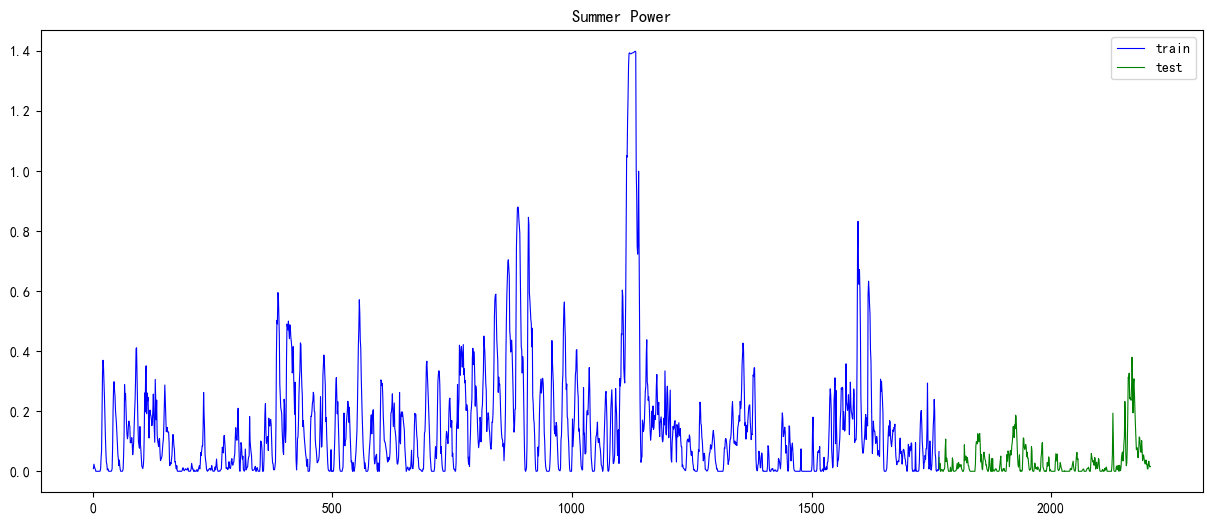

In [17]:
#对夏天的训练集和测试集进行可视化
t2_1=range(1,len(train_summer)+1)
t2_2=range(len(train_summer),len(summer))
plt.figure(figsize=(15,6))
plt.plot(t2_1,train_summer["power"],color='blue', linewidth=0.8,label='train')
plt.plot(t2_2,test_summer["power"],color='green', linewidth=0.8,label='test')
plt.title("Summer Power")
plt.legend()
plt.show()

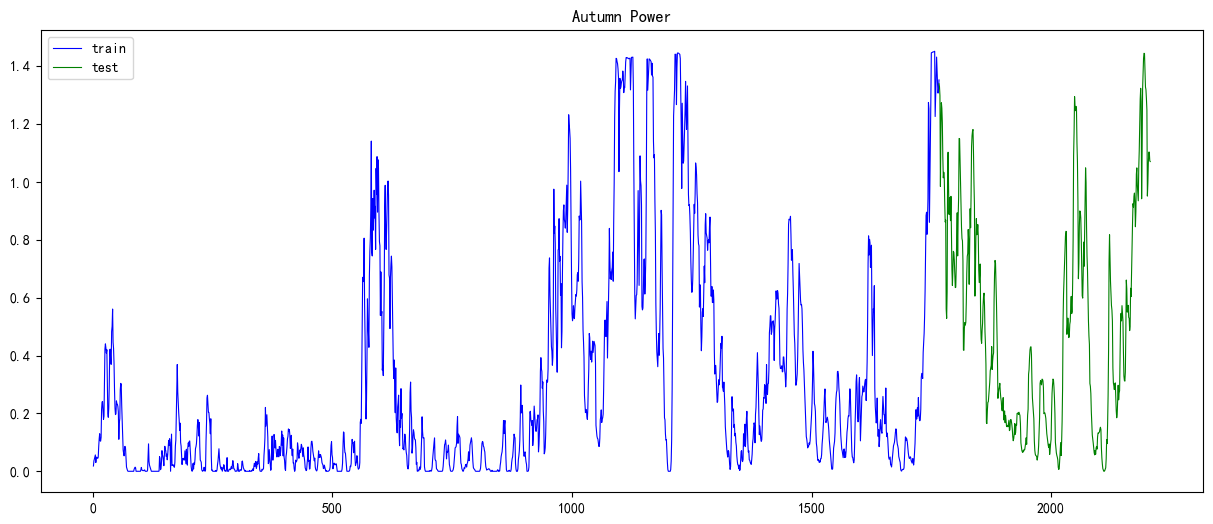

In [18]:
#对秋天的训练集和测试集进行可视化
t2_1=range(1,len(train_autumn)+1)
t2_2=range(len(train_autumn),len(autumn))
plt.figure(figsize=(15,6))
plt.plot(t2_1,train_autumn["power"],color='blue', linewidth=0.8,label='train')
plt.plot(t2_2,test_autumn["power"],color='green', linewidth=0.8,label='test')
plt.title("Autumn Power")
plt.legend()
plt.show()

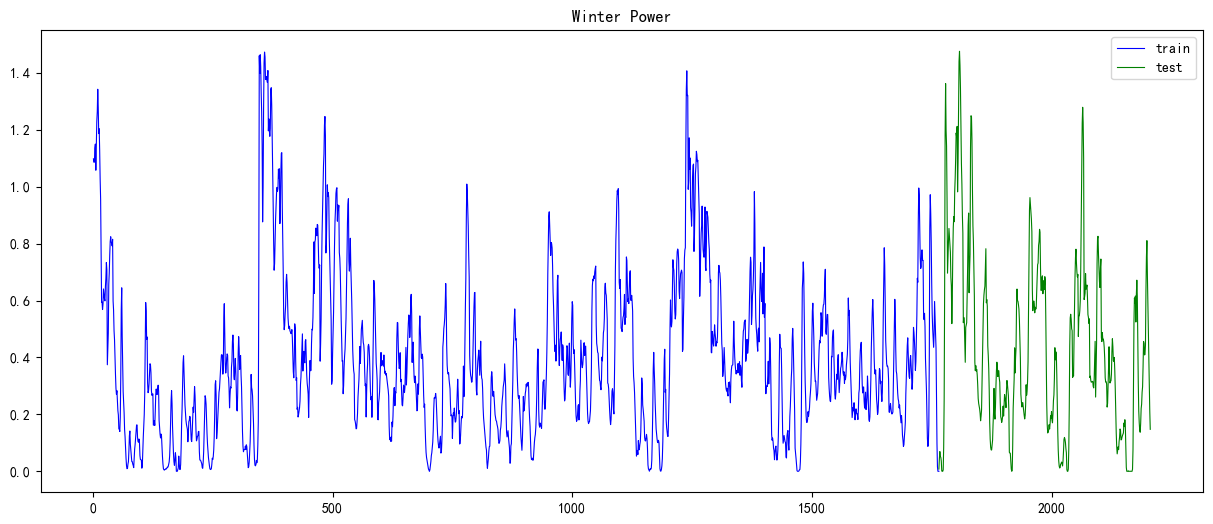

In [19]:
#对冬天的训练集和测试集进行可视化
t2_1=range(1,len(train_winter)+1)
t2_2=range(len(train_winter),len(winter))
plt.figure(figsize=(15,6))
plt.plot(t2_1,train_winter["power"],color='blue', linewidth=0.8,label='train')
plt.plot(t2_2,test_winter["power"],color='green', linewidth=0.8,label='test')
plt.title("Winter Power")
plt.legend()
plt.show()

In [20]:
#对训练集和测试集分别进行归一化，以防数据泄露
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
# 实例化 MinMaxScaler
scaler = MinMaxScaler()
# 使用 MinMaxScaler 进行归一化
scaler_train_spring = scaler.fit_transform(train_spring)
scaler_test_spring = scaler.fit_transform(test_spring)
scaler_train_summer = scaler.fit_transform(train_summer)
scaler_test_summer = scaler.fit_transform(test_summer)
scaler_train_autumn = scaler.fit_transform(train_autumn)
scaler_test_autumn = scaler.fit_transform(test_autumn)
scaler_train_winter = scaler.fit_transform(train_winter)
scaler_test_winter = scaler.fit_transform(test_winter)

In [21]:
####第一种定义识别坡道

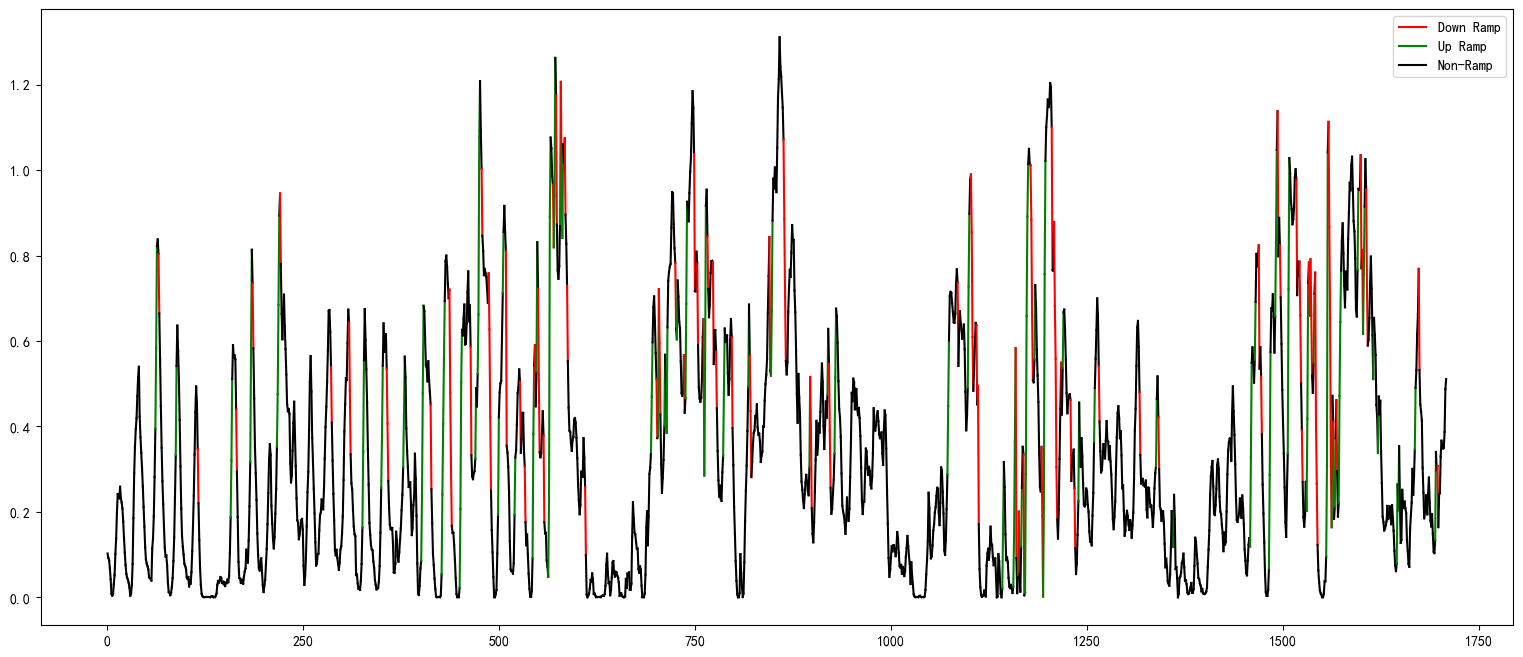

绿色线段数量: 115
红色线段数量: 106


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# 取出第一列的元素
spring_power = train_spring["power"]
def fit_line(data, time_interval, threshold):
    x = np.arange(1, len(data) + 1)  # x从1开始，以便与data的索引对应
    y = np.array(data)
    
    colors = []
    green_count = 0
    red_count = 0
    labels_ct1 = []
    for i in range(1, len(data)):  # 从1开始，避免索引0的问题
        diff = (y[i] - y[i-1]) /time_interval  # 计算相邻点之间的差异
        if diff > threshold:
            colors.append('green')
            labels_ct1.append(-1)
            green_count += 1
        elif diff < -threshold:
            colors.append('red')
            labels_ct1.append(1)
            red_count += 1
        else:
            colors.append('black')
            labels_ct1.append(0)

    # 绘制线条
    plt.figure(figsize=(19,8))
    for i in range(1, len(x)):  # 从1开始绘制，避免绘制第一个点
        plt.plot([x[i-1], x[i]], [y[i-1], y[i]], color=colors[i-1])  # 使用i-1来索引colors列表
    # 添加图例项，这里不绘制到图上，仅用于图例展示
    plt.plot([], [], color='red', linestyle='-', label='Down Ramp')
    plt.plot([], [], color='green', linestyle='-', label='Up Ramp')
    plt.plot([], [], color='black', linestyle='-', label='Non-Ramp')
    # 显示图例
    plt.legend()
    plt.show()

    # 返回绿红线条的数量
    return green_count, red_count,labels_ct1

# 调用函数并获取颜色计数
time_interval=4
threshold=0.03
green_count, red_count,labels_ct1 = fit_line(spring_power,time_interval,threshold)

print(f"绿色线段数量: {green_count}")
print(f"红色线段数量: {red_count}")
#print("标签列表：", labels_ct1)

In [23]:
#####第二种定义识别坡道段

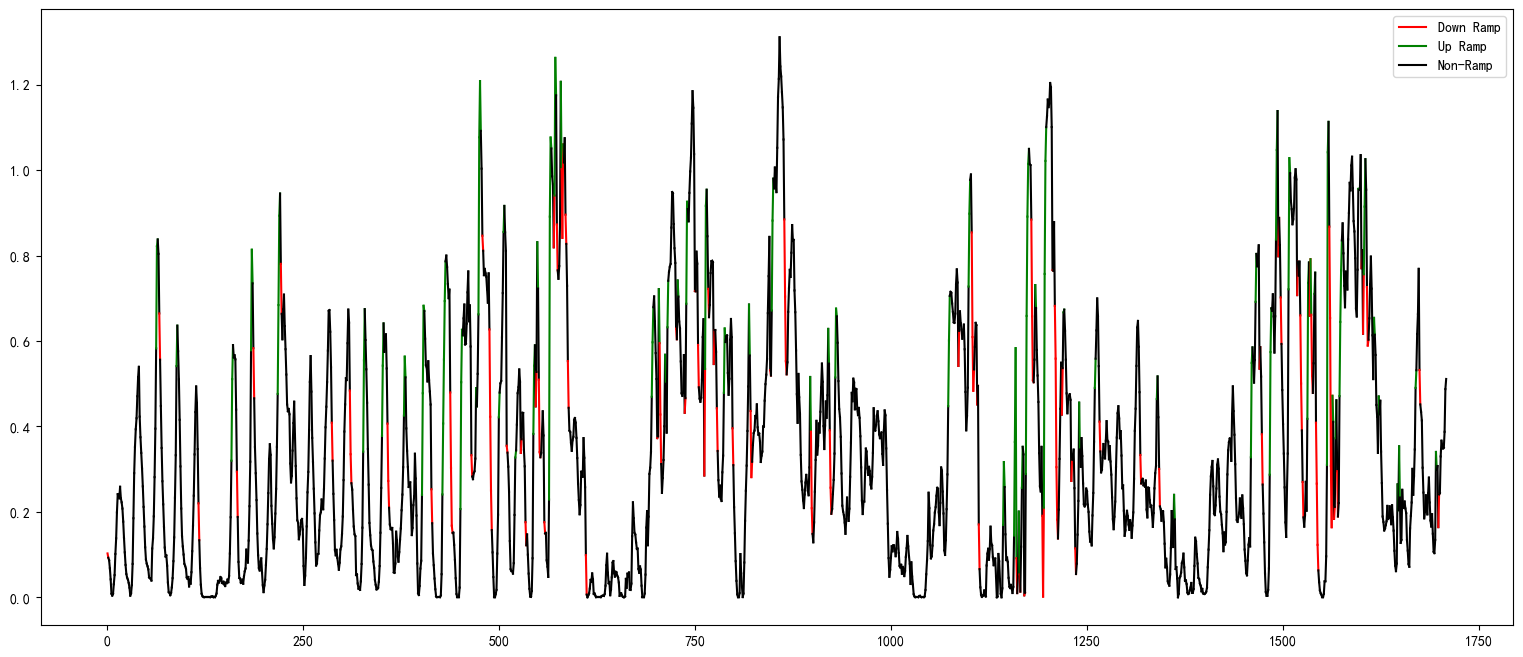

绿色线段数量: 115
红色线段数量: 107


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

spring_power = train_spring["power"]

def fit_line(data, threshold):
    x = np.arange(1, len(data) + 1)
    y = np.array(data)
    
    # 用于跟踪颜色的列表
    colors = []# 用于计算绿红线条数量的计数器
    green_count = 0
    red_count = 0
    labels_ct2 = []  # 用于存储每个数据点的标签

    for i in range(0, len(data)):
        diff = (y[i] - y[i-1])
        if diff > threshold:
            colors.append('green')
            labels_ct2.append(1)
            green_count += 1
        elif diff < -threshold:
            colors.append('red')
            labels_ct2.append(-1)
            red_count += 1
        else:
            colors.append('black')
            labels_ct2.append(0)

    # 绘制线条
    plt.figure(figsize=(19,8))
    for i in range(1, len(x)):  # 从1开始绘制，避免绘制第一个点
        plt.plot([x[i-1], x[i]], [y[i-1], y[i]], color=colors[i-1])  # 使用i-1来索引colors列表
    # 添加图例项，这里不绘制到图上，仅用于图例展示
    plt.plot([], [], color='red', linestyle='-', label='Down Ramp')
    plt.plot([], [], color='green', linestyle='-', label='Up Ramp')
    plt.plot([], [], color='black', linestyle='-', label='Non-Ramp')
    # 显示图例
    plt.legend()
    plt.show()

    # 返回绿红线条的数量
    return green_count, red_count,labels_ct2

threshold = 0.12
# 调用函数并获取颜色计数

green_count, red_count,labels_ct2 = fit_line(spring_power, threshold)

print(f"绿色线段数量: {green_count}")
print(f"红色线段数量: {red_count}")
#print("标签列表：", labels_ct2)

In [25]:
#第三种定义识别坡道

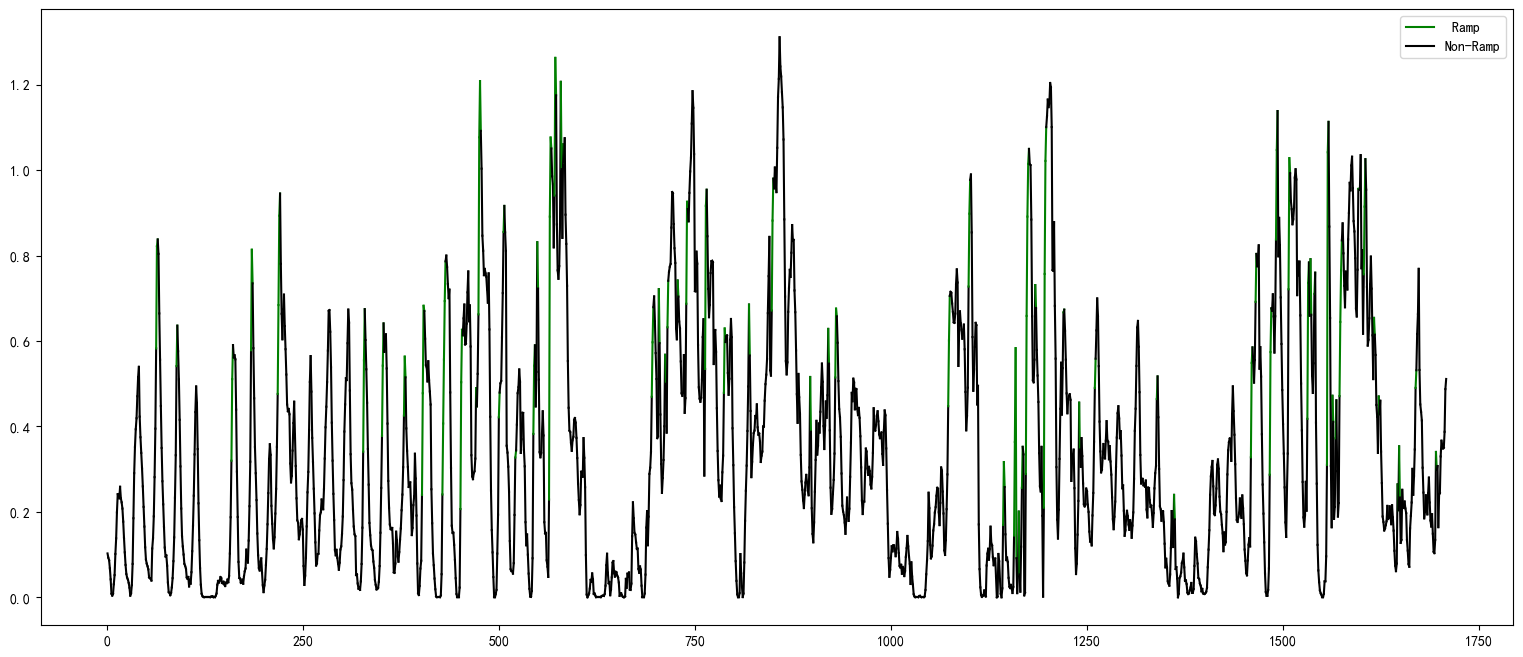

绿色线段数量: 115
红色线段数量: 0


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

spring_power = train_spring["power"]

def max_min_difference(data):
    result = []
    for i in range(0, len(data), 4):
        sub_data = data[i:i+4]
        max_value = max(sub_data)
        min_value = min(sub_data)
        difference = max_value - min_value
        result.append(difference)
    return result

result = max_min_difference(spring_power)
diff=np.array(result)#将列表转为数组

def fit_line(data, threshold):
    x = np.arange(1, len(data) + 1)
    y = np.array(data)
    
    # 用于跟踪颜色的列表
    colors = []
    # 用于计算绿红线条数量的计数器
    green_count = 0
    red_count = 0
    labels_ct3 = []  # 用于存储每个数据点的标签

    for i in range(0, len(data)):
        diff = (y[i] - y[i-1])
        if diff >= threshold:
            colors.append('green')
            labels_ct3.append(1)
            green_count += 1
        else:
            colors.append('black')
            labels_ct3.append(0)

    # 绘制线条
    plt.figure(figsize=(19,8))
    for i in range(1, len(x)):  # 从1开始绘制，避免绘制第一个点
        plt.plot([x[i-1], x[i]], [y[i-1], y[i]], color=colors[i-1])  # 使用i-1来索引colors列表

    plt.plot([], [], color='green', linestyle='-', label=' Ramp')
    plt.plot([], [], color='black', linestyle='-', label='Non-Ramp')
    # 显示图例
    plt.legend()
    plt.show()

    # 返回绿红线条的数量
    return green_count, red_count,labels_ct3

threshold = 0.12

# 调用函数并获取颜色计数

green_count, red_count,labels_ct3 = fit_line(spring_power, threshold)

print(f"绿色线段数量: {green_count}")
print(f"红色线段数量: {red_count}")
#print("标签列表：", labels_ct3)

In [27]:
###对夏天的数据进行坡道检测

In [28]:
#第一种坡道定义识别
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# 取出第一列的元素
summer_power = train_summer["power"]
def fit_line(data, time_interval, threshold):
    x = np.arange(1, len(data) + 1)  # x从1开始，以便与data的索引对应
    y = np.array(data)
    
    colors = []
    green_count = 0
    red_count = 0
    labels_xt1 = []
    for i in range(1, len(data)):  # 从1开始，避免索引0的问题
        diff = (y[i] - y[i-1]) /time_interval  # 计算相邻点之间的差异
        if diff > threshold:
            colors.append('green')
            labels_xt1.append(-1)
            green_count += 1
        elif diff < -threshold:
            colors.append('red')
            labels_xt1.append(1)
            red_count += 1
        else:
            colors.append('black')
            labels_xt1.append(0)

    # 绘制线条
    plt.figure(figsize=(19,8))
    for i in range(1, len(x)):  # 从1开始绘制，避免绘制第一个点
        plt.plot([x[i-1], x[i]], [y[i-1], y[i]], color=colors[i-1])  # 使用i-1来索引colors列表
    # 添加图例项，这里不绘制到图上，仅用于图例展示
    plt.plot([], [], color='red', linestyle='-', label='Down Ramp')
    plt.plot([], [], color='green', linestyle='-', label='Up Ramp')
    plt.plot([], [], color='black', linestyle='-', label='Non-Ramp')
    # 显示图例
    plt.legend()
    plt.show()

    # 返回绿红线条的数量
    return green_count, red_count,labels_xt1

# 调用函数并获取颜色计数
time_interval=4
threshold=0.03
green_count, red_count,labels_xt1 = fit_line(summer_power,time_interval,threshold)

print(f"绿色线段数量: {green_count}")
print(f"红色线段数量: {red_count}")
#print("标签列表：", labels_xt1)

绿色线段数量: 51
红色线段数量: 39


In [29]:
#第二种坡道定义识别
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

summer_power = train_summer["power"]

def fit_line(data, threshold):
    x = np.arange(1, len(data) + 1)
    y = np.array(data)
    
    # 用于跟踪颜色的列表
    colors = []
    # 用于计算绿红线条数量的计数器
    green_count = 0
    red_count = 0
    labels_xt2 = []  # 用于存储每个数据点的标签

    for i in range(0, len(data)):
        diff = (y[i] - y[i-1])
        if diff > threshold:
            colors.append('green')
            labels_xt2.append(1)
            green_count += 1
        elif diff < -threshold:
            colors.append('red')
            labels_xt2.append(-1)
            red_count += 1
        else:
            colors.append('black')
            labels_xt2.append(0)

    # 绘制线条
    plt.figure(figsize=(19,8))
    for i in range(1, len(x)):  # 从1开始绘制，避免绘制第一个点
        plt.plot([x[i-1], x[i]], [y[i-1], y[i]], color=colors[i-1])  # 使用i-1来索引colors列表

    # 添加图例项，这里不绘制到图上，仅用于图例展示
    plt.plot([], [], color='red', linestyle='-', label='Down Ramp')
    plt.plot([], [], color='green', linestyle='-', label='Up Ramp')
    plt.plot([], [], color='black', linestyle='-', label='Non-Ramp')
    # 显示图例
    plt.legend()
    plt.show()

    # 返回绿红线条的数量
    return green_count, red_count,labels_xt2

threshold = 0.12

# 调用函数并获取颜色计数

green_count, red_count,labels_xt2 = fit_line(summer_power, threshold)

print(f"绿色线段数量: {green_count}")
print(f"红色线段数量: {red_count}")
#print("标签列表：", labels_xt2)

绿色线段数量: 51
红色线段数量: 39


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

summer_power = train_summer["power"]

def max_min_difference(data):
    result = []
    for i in range(0, len(data), 4):
        sub_data = data[i:i+4]
        max_value = max(sub_data)
        min_value = min(sub_data)
        difference = max_value - min_value
        result.append(difference)
    return result

result = max_min_difference(summer_power)
diff=np.array(result)#将列表转为数组

def fit_line(data, threshold):
    x = np.arange(1,len(data)+1)
    y = np.array(data)
    
    # 用于跟踪颜色的列表
    colors = []
    # 用于计算绿红线条数量的计数器
    green_count = 0
    red_count = 0
    labels_xt3 = []  # 用于存储每个数据点的标签

    for i in range(0, len(data)):
        diff = (y[i] - y[i-1])
        if diff >= threshold:
            colors.append('green')
            labels_xt3.append(1)
            green_count += 1
        else:
            colors.append('black')
            labels_xt3.append(0)

    # 绘制线条
    plt.figure(figsize=(19,8))
    for i in range(1, len(x)):  # 从1开始绘制，避免绘制第一个点
        plt.plot([x[i-1], x[i]], [y[i-1], y[i]], color=colors[i-1])  # 使用i-1来索引colors列表

    plt.plot([], [], color='green', linestyle='-', label='Ramp')
    plt.plot([], [], color='black', linestyle='-', label='Non-Ramp')
    # 显示图例
    plt.legend()
    plt.show()

    # 返回绿红线条的数量
    return green_count, red_count,labels_xt3

threshold = 0.12

# 调用函数并获取颜色计数

green_count, red_count,labels_xt3 = fit_line(summer_power, threshold)

print(f"绿色线段数量: {green_count}")
print(f"红色线段数量: {red_count}")
#print("标签列表：", labels_xt3)

绿色线段数量: 51
红色线段数量: 0


In [31]:
###对秋天的数据进行坡道检测

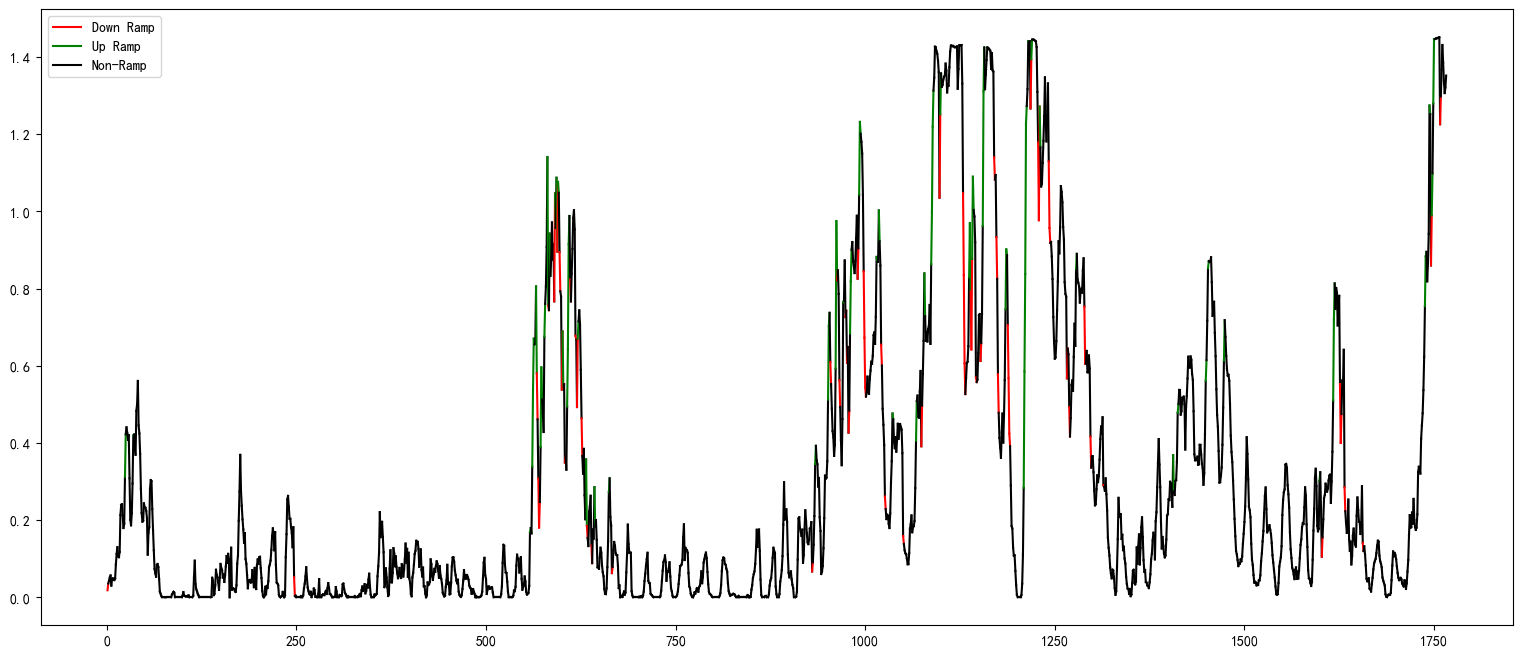

绿色线段数量: 72
红色线段数量: 66


In [32]:
#第一种坡道定义识别
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# 取出第一列的元素
autumn_power = train_autumn["power"]
def fit_line(data, time_interval, threshold):
    x = np.arange(1,len(data)+1)
    y = np.array(data)
    
    # 用于跟踪颜色的列表
    colors = []
    # 用于计算绿红线条数量的计数器
    green_count = 0
    red_count = 0
    labels_qt1 = []  # 用于存储每个数据点的标签
    for i in range(0, len(data)):
        diff = (y[i] - y[i-1]) / time_interval
        if diff > threshold:
            colors.append('green')
            labels_qt1.append(-1)
            green_count += 1
        elif diff < -threshold:
            colors.append('red')
            labels_qt1.append(1)
            red_count += 1
        else:
            colors.append('black')
            labels_qt1.append(0)

    # 绘制线条
    plt.figure(figsize=(19,8))
    for i in range(1, len(x)):  # 从1开始绘制，避免绘制第一个点
        plt.plot([x[i-1], x[i]], [y[i-1], y[i]], color=colors[i-1])  # 使用i-1来索引colors列表

    # 添加图例项，这里不绘制到图上，仅用于图例展示
    plt.plot([], [], color='red', linestyle='-', label='Down Ramp')
    plt.plot([], [], color='green', linestyle='-', label='Up Ramp')
    plt.plot([], [], color='black', linestyle='-', label='Non-Ramp')
    # 显示图例
    plt.legend()
    plt.show()

    # 返回绿红线条的数量
    return green_count, red_count,labels_qt1

# 调用函数并获取颜色计数
time_interval=4
threshold=0.03
green_count, red_count,labels_qt1 = fit_line(autumn_power,time_interval,threshold)

print(f"绿色线段数量: {green_count}")
print(f"红色线段数量: {red_count}")
#print("标签列表：", labels_qt1)

In [33]:
#对秋天的第二种坡道识别

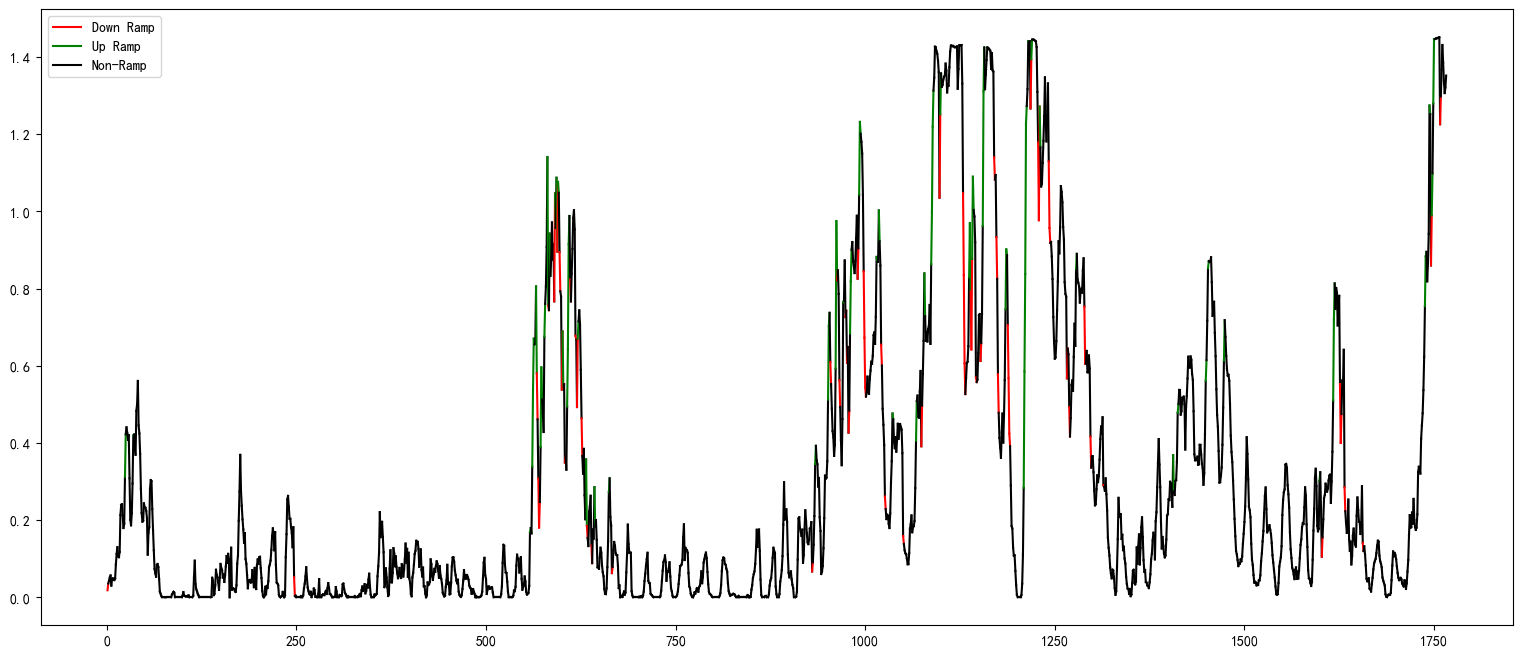

绿色线段数量: 72
红色线段数量: 66


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 取出第一列的元素
autumn_power = train_autumn["power"]
def fit_line(data, threshold):
    x = np.arange(1,len(data)+1)
    y = np.array(data)
    
    # 用于跟踪颜色的列表
    colors = []
    # 用于计算绿红线条数量的计数器
    green_count = 0
    red_count = 0
    labels_qt2 = []  # 用于存储每个数据点的标签

    for i in range(0, len(data)):
        diff = (y[i] - y[i-1])
        if diff > threshold:
            colors.append('green')
            labels_qt2.append(1)
            green_count += 1
        elif diff < -threshold:
            colors.append('red')
            labels_qt2.append(-1)
            red_count += 1
        else:
            colors.append('black')
            labels_qt2.append(0)

    # 绘制线条
    plt.figure(figsize=(19,8))
    for i in range(1, len(x)):  # 从1开始绘制，避免绘制第一个点
        plt.plot([x[i-1], x[i]], [y[i-1], y[i]], color=colors[i-1])  # 使用i-1来索引colors列表

    # 添加图例项，这里不绘制到图上，仅用于图例展示
    plt.plot([], [], color='red', linestyle='-', label='Down Ramp')
    plt.plot([], [], color='green', linestyle='-', label='Up Ramp')
    plt.plot([], [], color='black', linestyle='-', label='Non-Ramp')
    # 显示图例
    plt.legend()
    plt.show()

    # 返回绿红线条的数量
    return green_count, red_count,labels_qt2



threshold = 0.12

# 调用函数并获取颜色计数

green_count, red_count,labels_qt2 = fit_line(autumn_power, threshold)

print(f"绿色线段数量: {green_count}")
print(f"红色线段数量: {red_count}")
#print("标签列表：", labels_qt2)

In [35]:
#对秋天的第三种定义识别坡道

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

autumn_power = train_autumn["power"]

def max_min_difference(data):
    result = []
    for i in range(0, len(data), 4):
        sub_data = data[i:i+4]
        max_value = max(sub_data)
        min_value = min(sub_data)
        difference = max_value - min_value
        result.append(difference)
    return result

result = max_min_difference(autumn_power)
diff=np.array(result)#将列表转为数组

def fit_line(data, threshold):
    x = np.arange(1,len(data)+1)
    y = np.array(data)
    
    # 用于跟踪颜色的列表
    colors = []
    # 用于计算绿红线条数量的计数器
    green_count = 0
    red_count = 0
    labels_qt3 = []  # 用于存储每个数据点的标签

    for i in range(0, len(data)):
        diff = (y[i] - y[i-1])
        if diff >= threshold:
            colors.append('green')
            labels_qt3.append(1)
            green_count += 1
        else:
            colors.append('black')
            labels_qt3.append(0)

    # 绘制线条
    plt.figure(figsize=(19,8))
    for i in range(1, len(x)):  # 从1开始绘制，避免绘制第一个点
        plt.plot([x[i-1], x[i]], [y[i-1], y[i]], color=colors[i-1])  # 使用i-1来索引colors列表

    plt.plot([], [], color='green', linestyle='-', label='Ramp')
    plt.plot([], [], color='black', linestyle='-', label='Non-Ramp')
    # 显示图例
    plt.legend()
    plt.show()

    # 返回绿红线条的数量
    return green_count, red_count,labels_qt3

threshold = 0.12

# 调用函数并获取颜色计数

green_count, red_count,labels_qt3 = fit_line(autumn_power, threshold)

print(f"绿色线段数量: {green_count}")
print(f"红色线段数量: {red_count}")
#print("标签列表：", labels_qt3)

绿色线段数量: 72
红色线段数量: 0


In [37]:
###对冬天的数据进行坡道检测

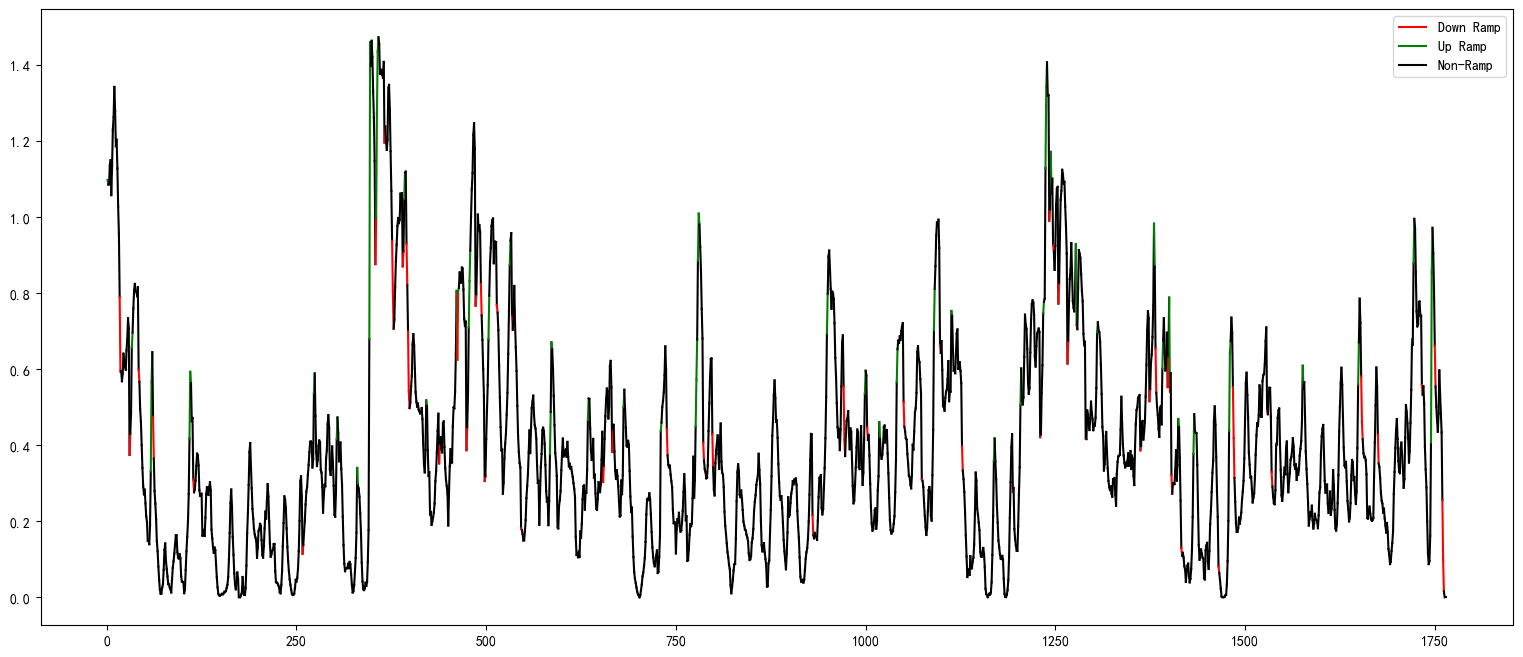

绿色线段数量: 60
红色线段数量: 65


In [38]:
#第一种坡道定义识别
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# 取出第一列的元素
winter_power =train_winter["power"]
def fit_line(data, time_interval, threshold):
    x = np.arange(1,len(data)+1)
    y = np.array(data)
    
    # 用于跟踪颜色的列表
    colors = []
    # 用于计算绿红线条数量的计数器
    green_count = 0
    red_count = 0
    labels_dt1 = []  # 用于存储每个数据点的标签
    for i in range(0, len(data)):
        diff = (y[i] - y[i-1]) / time_interval
        if diff > threshold:
            colors.append('green')
            labels_dt1.append(-1)
            green_count += 1
        elif diff < -threshold:
            colors.append('red')
            labels_dt1.append(1)
            red_count += 1
        else:
            colors.append('black')
            labels_dt1.append(0)

    # 绘制线条
    plt.figure(figsize=(19,8))
    for i in range(1, len(x)):  # 从1开始绘制，避免绘制第一个点
        plt.plot([x[i-1], x[i]], [y[i-1], y[i]], color=colors[i-1])  # 使用i-1来索引colors列表

    # 添加图例项，这里不绘制到图上，仅用于图例展示
    plt.plot([], [], color='red', linestyle='-', label='Down Ramp')
    plt.plot([], [], color='green', linestyle='-', label='Up Ramp')
    plt.plot([], [], color='black', linestyle='-', label='Non-Ramp')
    # 显示图例
    plt.legend()
    plt.show()

    # 返回绿红线条的数量
    return green_count, red_count,labels_dt1

# 调用函数并获取颜色计数
time_interval=4
threshold=0.03
green_count, red_count,labels_dt1 = fit_line(winter_power,time_interval,threshold)

print(f"绿色线段数量: {green_count}")
print(f"红色线段数量: {red_count}")
#print("标签列表：", labels_dt1)

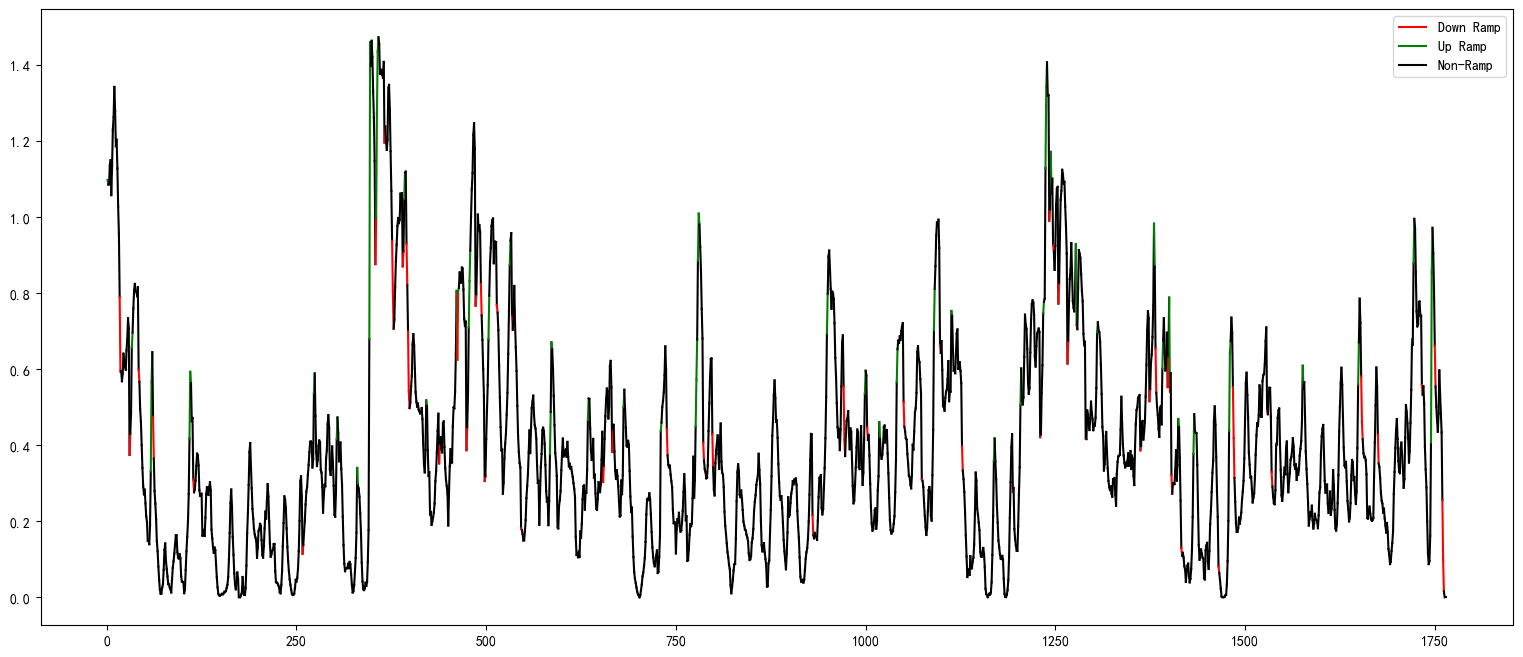

绿色线段数量: 60
红色线段数量: 65


In [39]:
#对冬天的第二种坡道识别
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

winter_power =train_winter["power"]
def fit_line(data, threshold):
    x = np.arange(1,len(data)+1)
    y = np.array(data)
    
    # 用于跟踪颜色的列表
    colors = []
    # 用于计算绿红线条数量的计数器
    green_count = 0
    red_count = 0
    labels_dt2 = []  # 用于存储每个数据点的标签

    for i in range(0, len(data)):
        diff = (y[i] - y[i-1])
        if diff > threshold:
            colors.append('green')
            labels_dt2.append(1)
            green_count += 1
        elif diff < -threshold:
            colors.append('red')
            labels_dt2.append(-1)
            red_count += 1
        else:
            colors.append('black')
            labels_dt2.append(0)

    # 绘制线条
    plt.figure(figsize=(19,8))
    for i in range(1, len(x)):  # 从1开始绘制，避免绘制第一个点
        plt.plot([x[i-1], x[i]], [y[i-1], y[i]], color=colors[i-1])  # 使用i-1来索引colors列表

    # 添加图例项，这里不绘制到图上，仅用于图例展示
    plt.plot([], [], color='red', linestyle='-', label='Down Ramp')
    plt.plot([], [], color='green', linestyle='-', label='Up Ramp')
    plt.plot([], [], color='black', linestyle='-', label='Non-Ramp')
    # 显示图例
    plt.legend()
    plt.show()

    # 返回绿红线条的数量
    return green_count, red_count,labels_dt2


threshold = 0.12

# 调用函数并获取颜色计数

green_count, red_count,labels_dt2 = fit_line(winter_power, threshold)

print(f"绿色线段数量: {green_count}")
print(f"红色线段数量: {red_count}")
#print("标签列表：", labels_dt2)

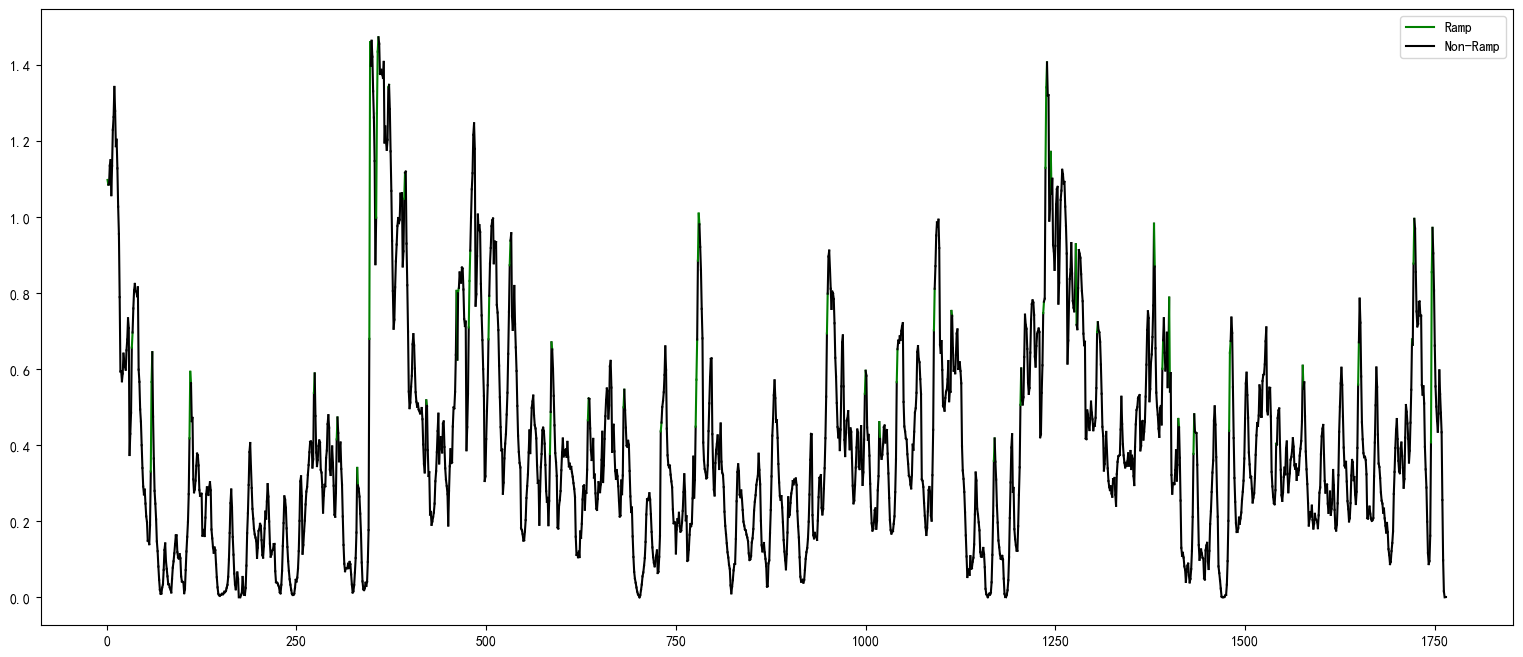

绿色线段数量: 60
红色线段数量: 0


In [40]:
#对冬天的第三种定义坡道识别
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

winter_power =train_winter["power"]

def max_min_difference(data):
    result = []
    for i in range(0, len(data), 4):
        sub_data = data[i:i+4]
        max_value = max(sub_data)
        min_value = min(sub_data)
        difference = max_value - min_value
        result.append(difference)
    return result

result = max_min_difference(winter_power)
diff=np.array(result)#将列表转为数组

def fit_line(data, time_interval, threshold):
    x = x = np.arange(1,len(data)+1)
    y = np.array(data)
    
    # 用于跟踪颜色的列表
    colors = []
    # 用于计算绿红线条数量的计数器
    green_count = 0
    red_count = 0
    labels_dt3 = []  # 用于存储每个数据点的标签

    for i in range(0, len(data)):
        diff = (y[i] - y[i-1])
        if diff >= threshold:
            colors.append('green')
            labels_dt3.append(1)
            green_count += 1
        else:
            colors.append('black')
            labels_dt3.append(0)

    # 绘制线条
    plt.figure(figsize=(19,8))
    for i in range(1, len(x)):  # 从1开始绘制，避免绘制第一个点
        plt.plot([x[i-1], x[i]], [y[i-1], y[i]], color=colors[i-1])  # 使用i-1来索引colors列表

    plt.plot([], [], color='green', linestyle='-', label='Ramp')
    plt.plot([], [], color='black', linestyle='-', label='Non-Ramp')
    # 显示图例
    plt.legend()
    plt.show()

    # 返回绿红线条的数量
    return green_count, red_count,labels_dt3

threshold = 0.12

# 调用函数并获取颜色计数

green_count, red_count,labels_dt3 = fit_line(winter_power, time_interval, threshold)

print(f"绿色线段数量: {green_count}")
print(f"红色线段数量: {red_count}")
#print("标签列表：", labels_dt3)

In [41]:
###对测试集使用第三种定义进行坡道识别

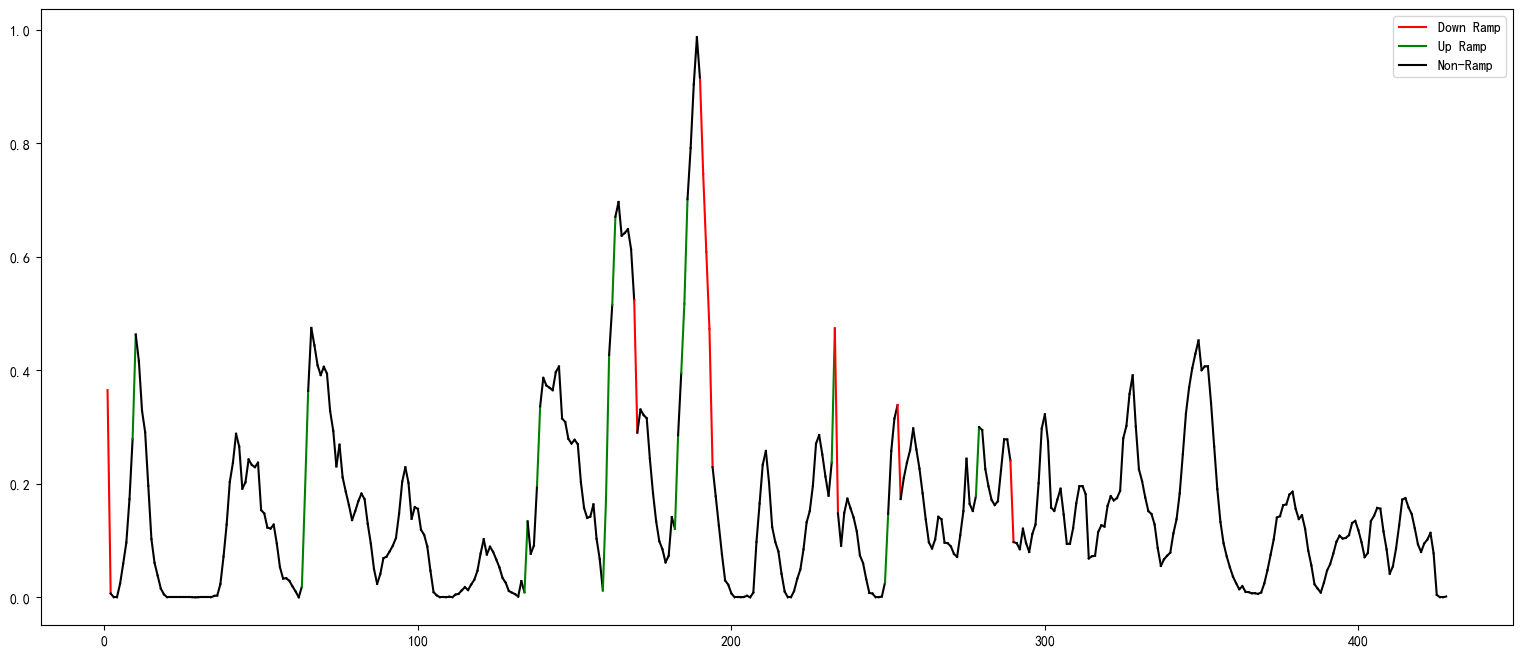

绿色线段数量: 14
红色线段数量: 9


In [42]:
#春天测试集
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# 取出第一列的元素
test_spring_power = test_spring["power"]
def fit_line(data, time_interval, threshold):
    x = np.arange(1, len(data) + 1)  # x从1开始，以便与data的索引对应
    y = np.array(data)
    
    colors = []
    green_count = 0
    red_count = 0
    labels_ctt1 = []
    for i in range(1, len(data)):  # 从1开始，避免索引0的问题
        diff = (y[i] - y[i-1]) /time_interval  # 计算相邻点之间的差异
        if diff > threshold:
            colors.append('green')
            labels_ctt1.append(-1)
            green_count += 1
        elif diff < -threshold:
            colors.append('red')
            labels_ctt1.append(1)
            red_count += 1
        else:
            colors.append('black')
            labels_ctt1.append(0)

    # 绘制线条
    plt.figure(figsize=(19,8))
    for i in range(1, len(x)):  # 从1开始绘制，避免绘制第一个点
        plt.plot([x[i-1], x[i]], [y[i-1], y[i]], color=colors[i-1])  # 使用i-1来索引colors列表
    # 添加图例项，这里不绘制到图上，仅用于图例展示
    plt.plot([], [], color='red', linestyle='-', label='Down Ramp')
    plt.plot([], [], color='green', linestyle='-', label='Up Ramp')
    plt.plot([], [], color='black', linestyle='-', label='Non-Ramp')
    # 显示图例
    plt.legend()
    plt.show()

    # 返回绿红线条的数量
    return green_count, red_count,labels_ctt1

# 调用函数并获取颜色计数
time_interval=4
threshold=0.03
green_count, red_count,labels_ctt1 = fit_line(test_spring_power,time_interval,threshold)

print(f"绿色线段数量: {green_count}")
print(f"红色线段数量: {red_count}")
#print("标签列表：", labels_ctt1)

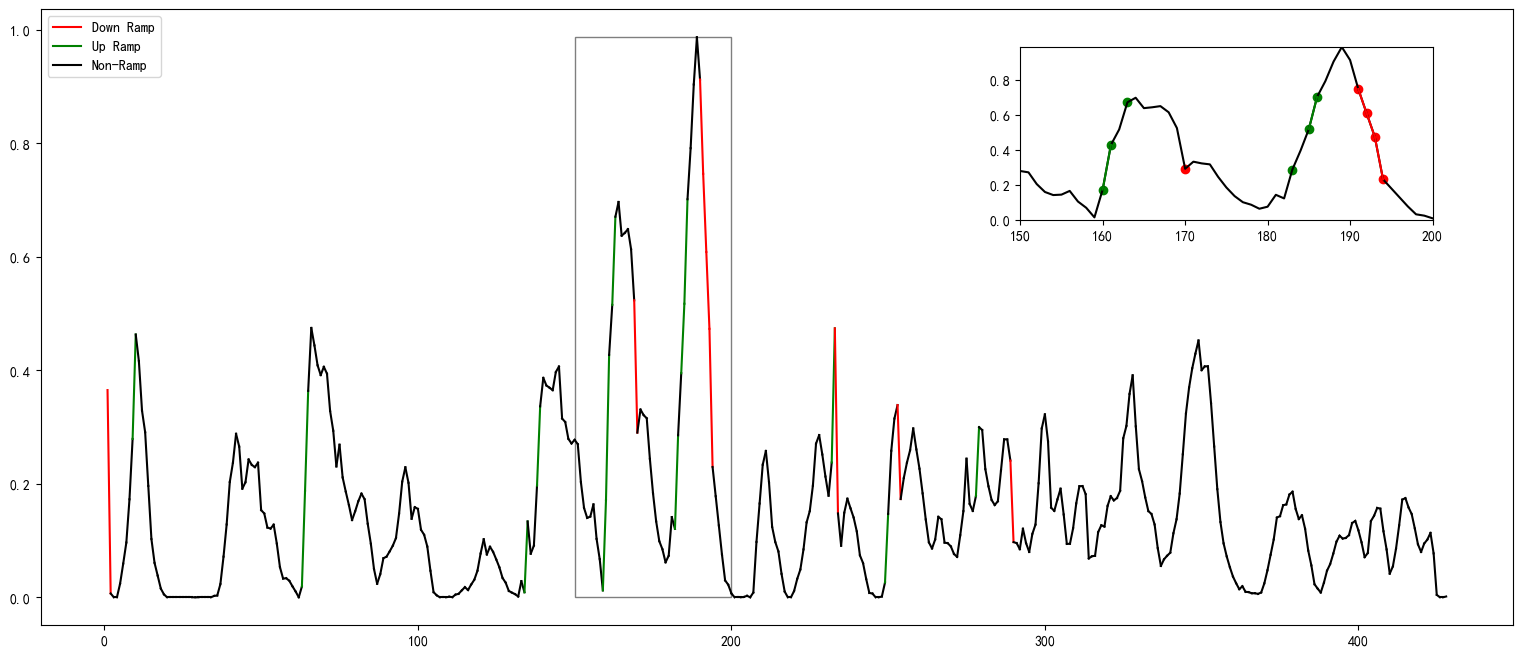

绿色线段数量: 14
红色线段数量: 9


In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# 取出第一列的元素
test_spring_power = test_spring["power"]

def fit_line(data, time_interval, threshold):
    x = np.arange(1, len(data) + 1)  # x从1开始，以便与data的索引对应
    y = np.array(data)
    
    colors = []
    green_count = 0
    red_count = 0
    labels_ctt1 = []
    for i in range(1, len(data)):  # 从1开始，避免索引0的问题
        diff = (y[i] - y[i-1]) / time_interval  # 计算相邻点之间的差异
        if diff > threshold:
            colors.append('green')
            labels_ctt1.append(-1)
            green_count += 1
        elif diff < -threshold:
            colors.append('red')
            labels_ctt1.append(1)
            red_count += 1
        else:
            colors.append('black')
            labels_ctt1.append(0)

    # 绘制线条
    fig, ax = plt.subplots(figsize=(19,8))
    for i in range(1, len(x)):  # 从1开始绘制，避免绘制第一个点
        ax.plot([x[i-1], x[i]], [y[i-1], y[i]], color=colors[i-1])  # 使用i-1来索引colors列表

    # 添加图例项，这里不绘制到图上，仅用于图例展示
    ax.plot([], [], color='red', linestyle='-', label='Down Ramp')
    ax.plot([], [], color='green', linestyle='-', label='Up Ramp')
    ax.plot([], [], color='black', linestyle='-', label='Non-Ramp')
    # 显示图例
    ax.legend()

    # 放大特定区域
    # 设置放大图的宽度和高度
    axins = inset_axes(ax, width="80%", height="80%", loc='upper right',
                       bbox_to_anchor=(0.6, 0.6, 0.35, 0.35), bbox_transform=ax.transAxes)
    x1, x2, y1, y2 = 150, 200, min(y), max(y)  # 定义放大区域的x和y范围
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.plot(x[x1-1:x2], y[x1-1:x2], color='black')  # 绘制放大的折线图

    # 在放大区域中标注绿色的圆点并用绿色线条连接
    for i in range(x1, x2):
        if colors[i-1] == 'green':
            axins.scatter(x[i], y[i], color='green')
            if i < x2 and colors[i] == 'green':
                axins.plot([x[i], x[i+1]], [y[i], y[i+1]], color='green')

    # 在放大区域中标注红色的圆点并用红色线条连接
    for i in range(x1, x2):
        if colors[i-1] == 'red':
            axins.scatter(x[i], y[i], color='red')
            if i < x2 and colors[i] == 'red':
                axins.plot([x[i], x[i+1]], [y[i], y[i+1]], color='red')

    # 连接放大区域和主图的线
    ax.indicate_inset_zoom(axins, edgecolor="black")
    plt.show()

    # 返回绿红线条的数量
    return green_count, red_count, labels_ctt1

# 调用函数并获取颜色计数
time_interval = 4
threshold = 0.03
green_count, red_count, labels_ctt1 = fit_line(test_spring_power, time_interval, threshold)

print(f"绿色线段数量: {green_count}")
print(f"红色线段数量: {red_count}")

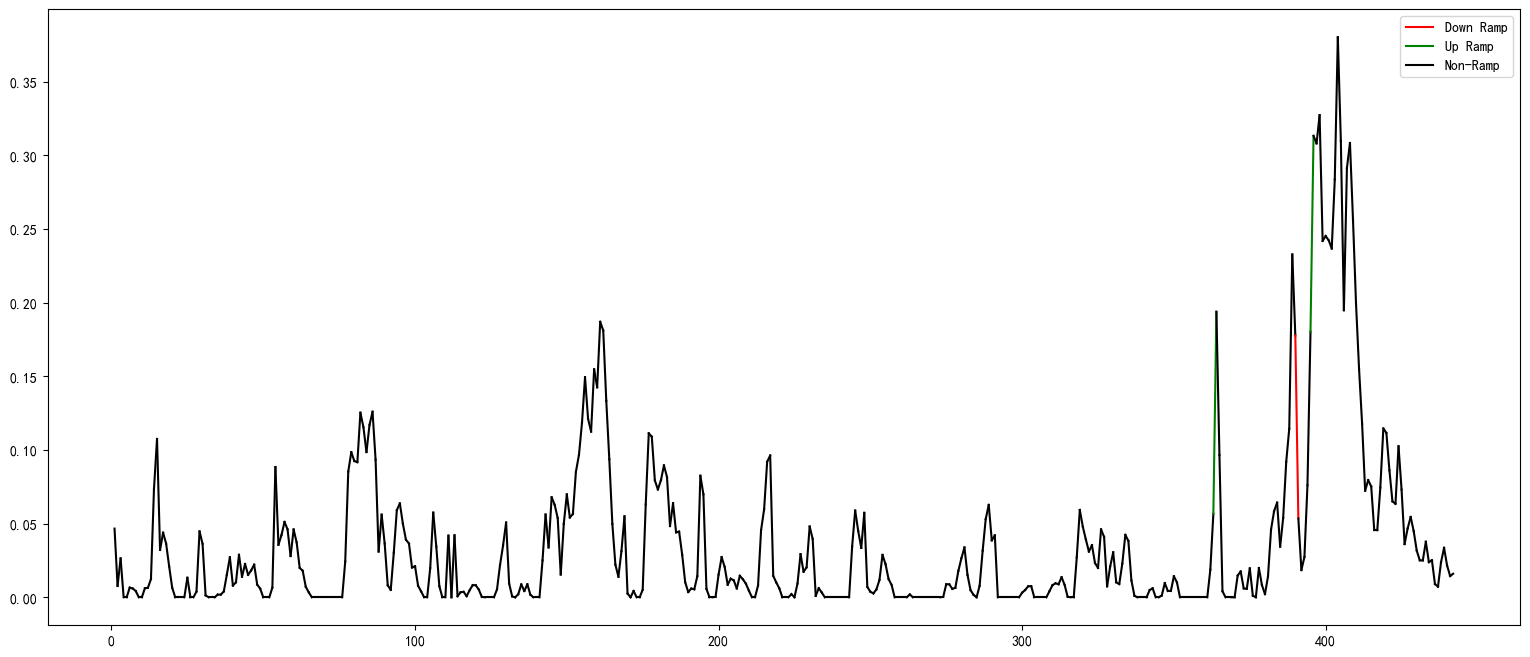

绿色线段数量: 2
红色线段数量: 1


In [90]:
#夏天测试集
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# 取出第一列的元素
test_summer_power =test_summer["power"]
def fit_line(data, time_interval, threshold):
    x = np.arange(1, len(data) + 1)  # x从1开始，以便与data的索引对应
    y = np.array(data)
    
    colors = []
    green_count = 0
    red_count = 0
    labels_xtt1 = []
    for i in range(1, len(data)):  # 从1开始，避免索引0的问题
        diff = (y[i] - y[i-1]) /time_interval  # 计算相邻点之间的差异
        if diff > threshold:
            colors.append('green')
            labels_xtt1.append(-1)
            green_count += 1
        elif diff < -threshold:
            colors.append('red')
            labels_xtt1.append(1)
            red_count += 1
        else:
            colors.append('black')
            labels_xtt1.append(0)

    # 绘制线条
    plt.figure(figsize=(19,8))
    for i in range(1, len(x)):  # 从1开始绘制，避免绘制第一个点
        plt.plot([x[i-1], x[i]], [y[i-1], y[i]], color=colors[i-1])  # 使用i-1来索引colors列表
    # 添加图例项，这里不绘制到图上，仅用于图例展示
    plt.plot([], [], color='red', linestyle='-', label='Down Ramp')
    plt.plot([], [], color='green', linestyle='-', label='Up Ramp')
    plt.plot([], [], color='black', linestyle='-', label='Non-Ramp')
    # 显示图例
    plt.legend()
    plt.show()

    # 返回绿红线条的数量
    return green_count, red_count,labels_xtt1

# 调用函数并获取颜色计数
time_interval=4
threshold=0.03
green_count, red_count,labels_xtt1 = fit_line(test_summer_power,time_interval,threshold)

print(f"绿色线段数量: {green_count}")
print(f"红色线段数量: {red_count}")
#print("标签列表：", labels_xtt1)

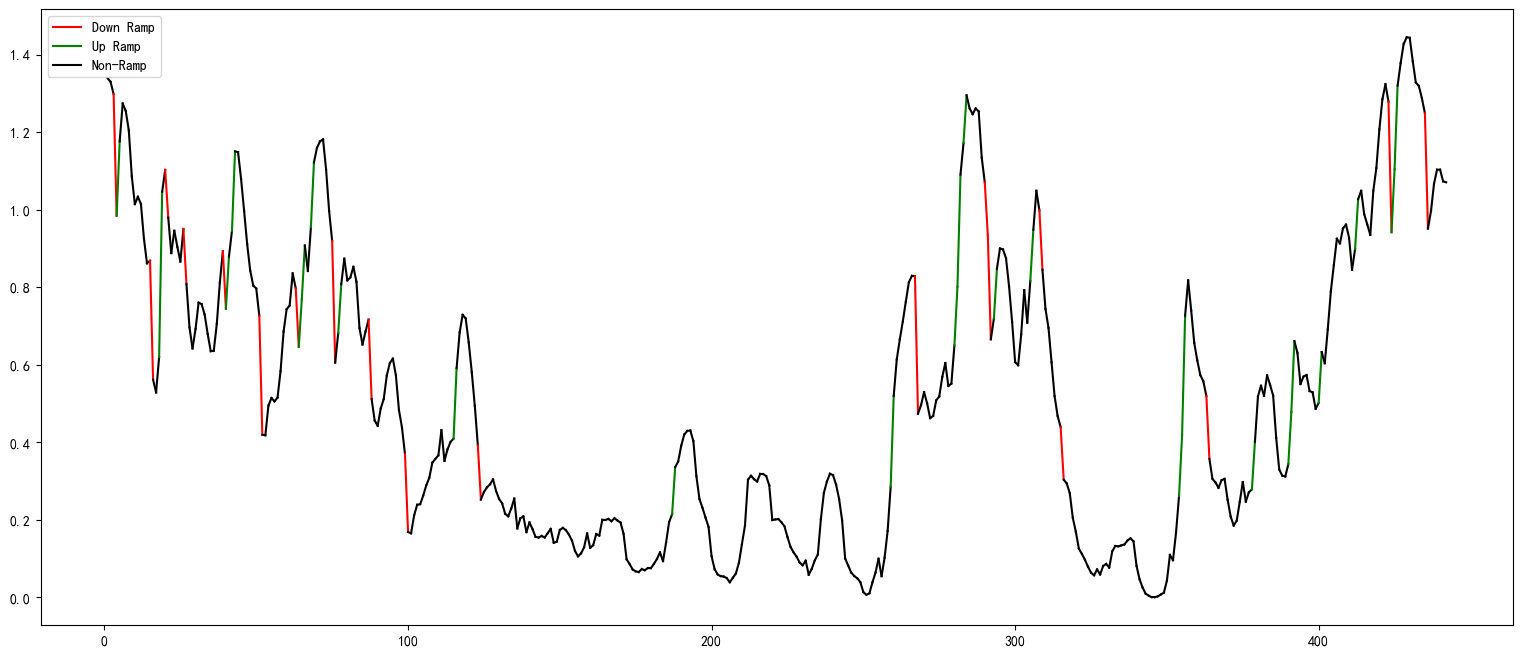

绿色线段数量: 25
红色线段数量: 19


In [91]:
#秋天测试集
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# 取出第一列的元素
test_autumn_power =test_autumn["power"]
def fit_line(data, time_interval, threshold):
    x = np.arange(1, len(data) + 1)  # x从1开始，以便与data的索引对应
    y = np.array(data)
    
    colors = []
    green_count = 0
    red_count = 0
    labels_qtt1 = []
    for i in range(1, len(data)):  # 从1开始，避免索引0的问题
        diff = (y[i] - y[i-1]) /time_interval  # 计算相邻点之间的差异
        if diff > threshold:
            colors.append('green')
            labels_qtt1.append(-1)
            green_count += 1
        elif diff < -threshold:
            colors.append('red')
            labels_qtt1.append(1)
            red_count += 1
        else:
            colors.append('black')
            labels_qtt1.append(0)

    # 绘制线条
    plt.figure(figsize=(19,8))
    for i in range(1, len(x)):  # 从1开始绘制，避免绘制第一个点
        plt.plot([x[i-1], x[i]], [y[i-1], y[i]], color=colors[i-1])  # 使用i-1来索引colors列表
    # 添加图例项，这里不绘制到图上，仅用于图例展示
    plt.plot([], [], color='red', linestyle='-', label='Down Ramp')
    plt.plot([], [], color='green', linestyle='-', label='Up Ramp')
    plt.plot([], [], color='black', linestyle='-', label='Non-Ramp')
    # 显示图例
    plt.legend()
    plt.show()

    # 返回绿红线条的数量
    return green_count, red_count,labels_qtt1

# 调用函数并获取颜色计数
time_interval=4
threshold=0.03
green_count, red_count,labels_qtt1 = fit_line(test_autumn_power,time_interval,threshold)

print(f"绿色线段数量: {green_count}")
print(f"红色线段数量: {red_count}")
#print("标签列表：", labels_qtt1)

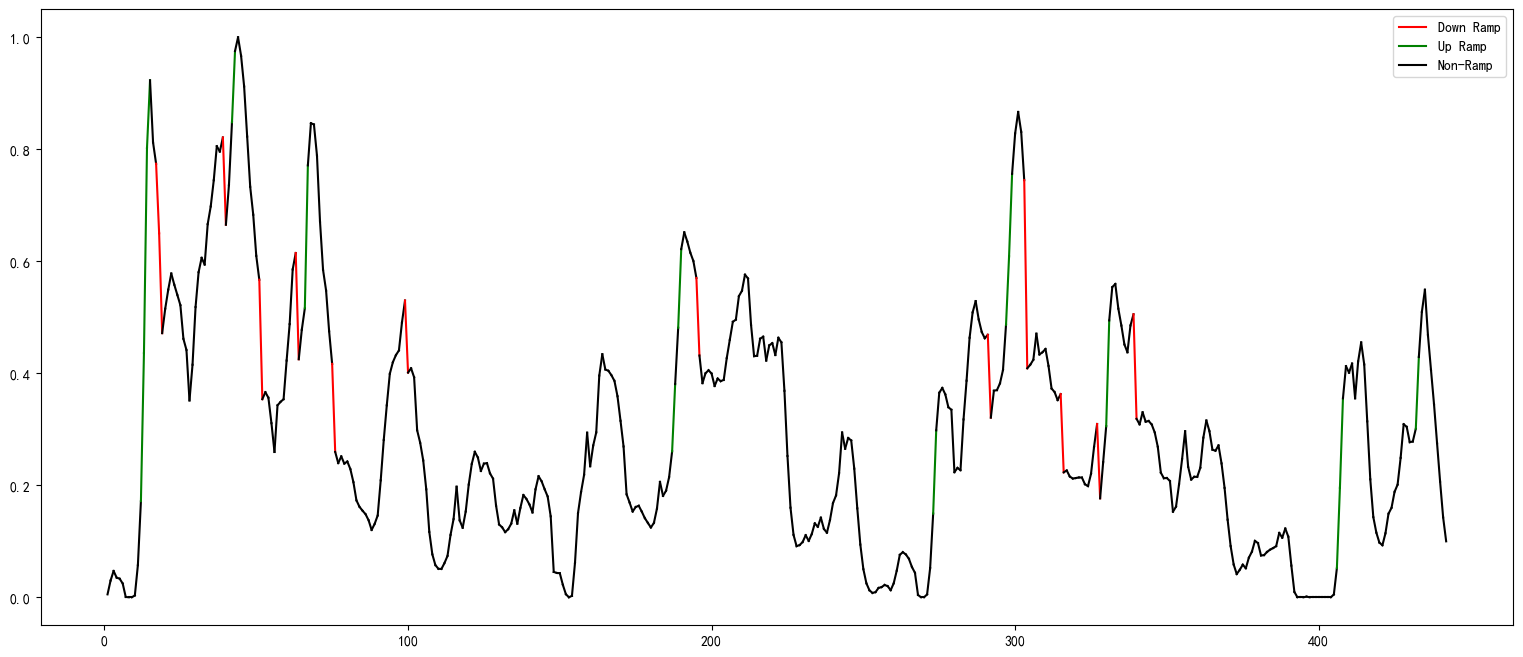

绿色线段数量: 14
红色线段数量: 13


In [92]:
#冬天测试集
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# 取出第一列的元素
test_winter_power = [row[0] for row in scaler_test_winter]
def fit_line(data, time_interval, threshold):
    x = np.arange(1,len(data)+1)  # x从1开始，以便与data的索引对应
    y = np.array(data)
    
    colors = []
    green_count = 0
    red_count = 0
    labels_dtt1 = []
    for i in range(1, len(data)):  # 从1开始，避免索引0的问题
        diff = (y[i] - y[i-1]) /time_interval  # 计算相邻点之间的差异
        if diff > threshold:
            colors.append('green')
            labels_dtt1.append(-1)
            green_count += 1
        elif diff < -threshold:
            colors.append('red')
            labels_dtt1.append(1)
            red_count += 1
        else:
            colors.append('black')
            labels_dtt1.append(0)

    # 绘制线条
    plt.figure(figsize=(19,8))
    for i in range(1, len(x)):  # 从1开始绘制，避免绘制第一个点
        plt.plot([x[i-1], x[i]], [y[i-1], y[i]], color=colors[i-1])  # 使用i-1来索引colors列表
    # 添加图例项，这里不绘制到图上，仅用于图例展示
    plt.plot([], [], color='red', linestyle='-', label='Down Ramp')
    plt.plot([], [], color='green', linestyle='-', label='Up Ramp')
    plt.plot([], [], color='black', linestyle='-', label='Non-Ramp')
    # 显示图例
    plt.legend()
    plt.show()

    # 返回绿红线条的数量
    return green_count, red_count,labels_dtt1

# 调用函数并获取颜色计数
time_interval=4
threshold=0.03
green_count, red_count,labels_dtt1 = fit_line(test_winter_power,time_interval,threshold)

print(f"绿色线段数量: {green_count}")
print(f"红色线段数量: {red_count}")
#print("标签列表：", labels_dtt1)

In [93]:
labels_ct1=labels_ct1+[0]
labels_xt1=labels_xt1+[0]

In [94]:
###选择第一种坡道识别对训练集进行标签标记
train_spring["labels"]=labels_ct1
train_spring.loc[train_spring['labels'] == -1, 'labels'] = 2
train_summer["labels"]=labels_xt1
train_summer.loc[train_summer['labels'] == -1, 'labels'] = 2
train_autumn["labels"]=labels_qt1
train_autumn.loc[train_autumn['labels'] == -1, 'labels'] = 2
train_winter["labels"]=labels_dt1
train_winter.loc[train_winter['labels'] == -1, 'labels'] = 2
train_winter

power  windspeed        tem     pressure    wind_dir  labels
0     1.098059  10.305530  21.718286  1017.108984   53.386604       2
1     1.085875  10.260178  21.520135  1016.779609   53.193535       0
2     1.086415  10.258954  21.252771  1016.678672   52.469666       0
3     1.135786  10.433625  20.947717  1016.466875   52.079926       0
4     1.150012  10.481876  20.768549  1016.585078   53.326035       0
...        ...        ...        ...          ...         ...     ...
1760  0.097290   4.640178  24.875879  1009.835859  179.190857       1
1761  0.015547   3.112696  25.386926  1009.656641  187.365768       0
1762  0.000000   1.722966  26.475031  1008.897188  200.177155       0
1763  0.000000   0.620854  28.504816  1008.043281  332.985901       0
1764  0.000000   1.455812  27.911829  1007.002188  358.530640       0

[1765 rows x 6 columns]

In [ ]:
#将得到的训练集和测试集保存至文档中
train_spring.to_excel(r'D:\article\train_spring.xlsx', index=False, engine='openpyxl')
train_summer.to_excel(r'D:\article\train_summer.xlsx', index=False, engine='openpyxl')
train_autumn.to_excel(r'D:\article\train_autumn.xlsx', index=False, engine='openpyxl')
train_winter.to_excel(r'D:\article\train_winter.xlsx', index=False, engine='openpyxl')

In [95]:
labels_ctt1=labels_ctt1+[0]
labels_xtt1=labels_xtt1+[0]
labels_qtt1=labels_qtt1+[0]
labels_dtt1=labels_dtt1+[0]

In [96]:
###选择第一种坡道识别对测试集进行标签标记
test_spring["labels"]=labels_ctt1
test_spring.loc[test_spring['labels'] == -1, 'labels'] = 2
test_summer["labels"]=labels_xtt1
test_summer.loc[test_summer['labels'] == -1, 'labels'] = 2
test_autumn["labels"]=labels_qtt1
test_autumn.loc[test_autumn['labels'] == -1, 'labels'] = 2
test_winter["labels"]=labels_dtt1
test_winter.loc[test_winter['labels'] == -1, 'labels'] = 2
test_winter

power  windspeed        tem     pressure   wind_dir  labels
1765  0.007676   2.739449  27.049005  1006.592188  13.605881       0
1766  0.044000   3.752334  26.758905  1006.208281  30.731934       0
1767  0.069311   4.218548  26.183374  1006.583750  49.758957       0
1768  0.051850   3.917274  24.232446  1007.062188  55.761917       0
1769  0.048963   3.850303  23.661584  1007.847031  73.656395       0
...        ...        ...        ...          ...        ...     ...
2202  0.508828   7.866335  19.888696  1020.496563  74.131462       0
2203  0.406219   7.292643  19.953210  1021.386797  80.491699       0
2204  0.305067   6.632876  19.661249  1022.115938  86.484528       0
2205  0.210821   5.901687  19.595178  1022.217656  88.666824       0
2206  0.147463   5.239462  19.443109  1022.395781  83.481789       0

[442 rows x 6 columns]

In [ ]:
#将得到的训练集和测试集保存至文档中
test_spring.to_excel(r'D:\article\test_spring.xlsx', index=False, engine='openpyxl')
test_summer.to_excel(r'D:\article\test_summer.xlsx', index=False, engine='openpyxl')
test_autumn.to_excel(r'D:\article\test_autumn.xlsx', index=False, engine='openpyxl')
test_winter.to_excel(r'D:\article\test_winter.xlsx', index=False, engine='openpyxl')